In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pprint import pprint
import itertools

import cp
import base

## Generate random data

In [2]:
np.random.seed(0)
sizes = [10, 15, 20]
rank = 3
tensor, factors, norms, noise = cp.create_data(sizes, rank, noise_factor=0)
W = np.round(np.random.random(tensor.shape)).astype(np.int)
tensor[1-W] = 0

## Find decomposition with cp_wopt

In [3]:
cp_factors, result, _, log = cp.cp_wopt(tensor, W=W, method='cg', rank=rank, init='svd', gtol=1e-15)

print(result.message)
print(f'F(x): { 0.0003137312420869495}')
print(f'Number of iterations: {result.nit}')
print(f'Number of function evaluations: {result.nfev}')

Optimization terminated successfully.
F(x): 0.0003137312420869495
Number of iterations: 67
Number of function evaluations: 124


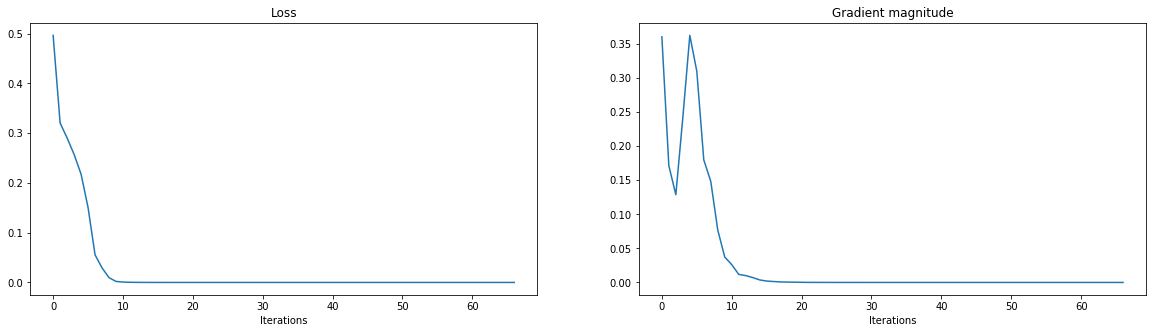

In [4]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(log.loss_values)
ax1.set_title('Loss')
ax1.set_xlabel('Iterations')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(log.gradient_values)
ax2.set_title('Gradient magnitude')
ax2.set_xlabel('Iterations')

#ax1.set_yscale('log')
#ax2.set_yscale('log')

plt.show()

## Check how well we recover the true factors

In [5]:
cp_factors_norm, cp_norms = cp.normalize_factors(cp_factors)
cp_weights = np.prod(np.concatenate(cp_norms), axis=0)

In [6]:
score, best_permutation = cp.compute_factor_match_score(factors, 
                                                        cp_factors_norm, 
                                                        true_weights=None, 
                                                        estimated_weights=cp_weights)

print(f'Factor match score: {score}')
print(f'Best match permutation: {best_permutation}')

Factor match score: 0.6767257090994928
Best match permutation: (0, 1, 2)


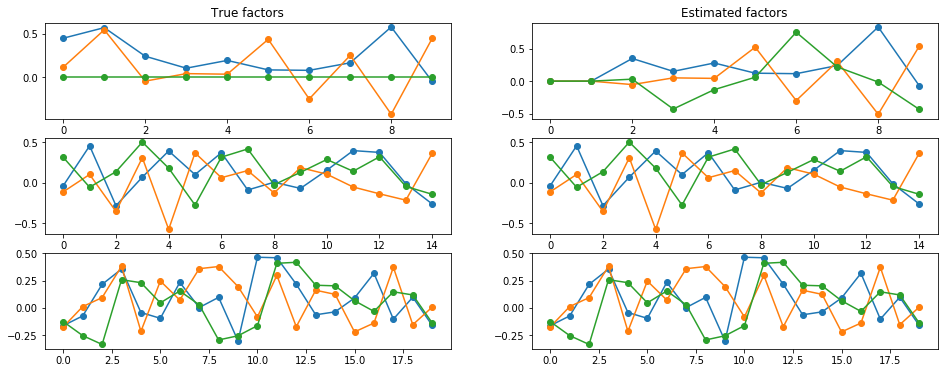

In [7]:
f1, s1, n1 = cp.prepare_for_comparison(factors)
f2, s2, n2 = cp.prepare_for_comparison(cp.permute_factors(best_permutation, cp_factors_norm))

fig, axes = plt.subplots(len(sizes), 2, figsize=(16, 6))
for i in range(len(factors)):
    axes[i][0].plot(f1[i], '-o')
    axes[0][0].set_title('True factors')
    
    axes[i][1].plot(f2[i], '-o')
    axes[0][1].set_title('Estimated factors')

plt.show()

## Tensor completion score

In [8]:
estimated_tensor = base.ktensor(*tuple(cp_factors))
tcs = cp.tensor_completion_score(tensor, estimated_tensor, W)
print(f"Tensor completion score: {tcs:g}")

Tensor completion score: 5.24505e-15


Text(0.5,1,'Estimated missing values')

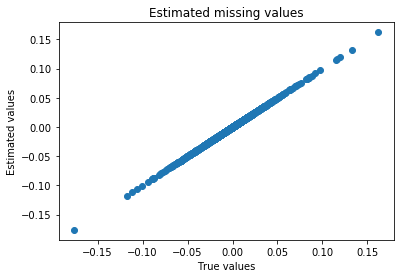

In [9]:
plt.plot(tensor[W==0], estimated_tensor[W==0], 'o')
plt.xlabel("True values")
plt.ylabel("Estimated values")
plt.title("Estimated missing values")